In [1]:
import sys

# sklearn ≥0.20 필수
import sklearn

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(21)

# 깔끔한 그래프 출력을 위해
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import platform
from matplotlib import font_manager, rc

# 매킨토시의 경우
if platform.system() == 'Darwin':
  rc('font', family='AppleGothic')
# 윈도우의 경우
elif platform.system() == 'Windows':
  font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
  rc('font', family=font_name)
  mpl.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "keras_multilayer_perceptron"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("그림 저장:", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.13.0


# Sequential API를 이용한 패션 이미지 분류기 만들기

## Fashion mnist 데이터 가져오기


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# 데이터 확인
print(X_train_full.shape) # 데이터 60000개, 2차원 흑백 이미지
print(type(X_train_full)) # numpy.ndarray

(60000, 28, 28)
<class 'numpy.ndarray'>


### 훈련 데이터와 테스트 데이터를 나누고 0 ~ 1 로 스케일링

In [4]:
# train_full 데이터 중에서 5000개는 validation에 사용하고 나머지는 train 에 사용
# 이미지 데이터이므로 값이 0 ~ 255 사이이므로 255로 나눠서 스케일링
X_valid, X_train = X_train_full[:5000] / 255, X_train_full[5000:]/255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255

### 이미지 출력해서 확인

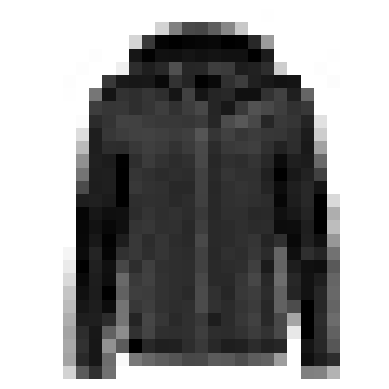

In [5]:
# 흑백 이미지이므로 cmap 으로 binary 를 사용
plt.imshow(X_train[0], cmap = 'binary')
plt.axis('off')
plt.show()

### 데이터 레이블

In [6]:
# 데이터의 레이블이 숫자로 되어 있음

print(y_train) # 0 ~ 9 사이의 숫자
# 유저 입장에서는 숫자 보다 문자열로 나타나는게 좋음

# 각 레이블 별 품목 명을 리스트로 생성
# 리스트로 나타내는게 아니라 대표하는 이미지로 생성하는 것도 방법
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# class name 확인
print(class_names[y_train[1]]) # 0번이므로 T-shirt/top

[4 0 7 ... 3 0 5]
T-shirt/top


### 데이터 크기 확인

In [7]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(55000, 28, 28)
(5000, 28, 28)
(10000, 28, 28)


그림 저장: fashion_mnist_plot


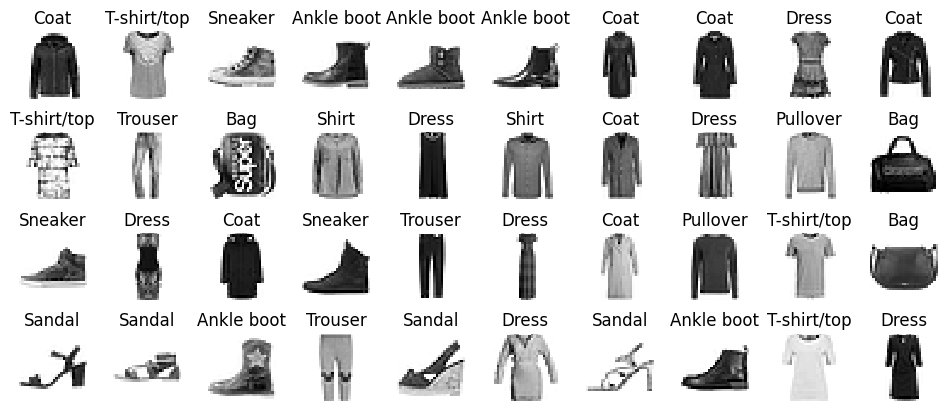

In [8]:
# 행 갯수
n_rows = 4
# 열 갯수
n_cols = 10
# 캔버스의 크기 설정
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

# 행과 열의 갯수만큼 순회
for row in range(n_rows):
  for col in range(n_cols):
    # 행과 열 번호를 가지고 인덱스를 생성
    index = n_cols * row + col
    # 작은 캔버스 안에 작은 캔버스를 순서대로 생성
    plt.subplot(n_rows, n_cols, index + 1)
    # 캔버스에 이미지를 하나씩 출력
    plt.imshow(X_train[index], cmap="binary", interpolation="nearest")

    plt.axis('off')
    # 작은 캔버스에 제목(문자열) 출력
    plt.title(class_names[y_train[index]], fontsize=12)

# 작은 캔버스 사이의 여백 설정
plt.subplots_adjust(wspace=0.2, hspace=0.5)

# 로컬에 이미지로 저장하는 함수 사용
# 첫번째 매개변수가 이미지 파일 이름
save_fig('fashion_mnist_plot', tight_layout=False)

# 출력
plt.show()

### Flatten layer

In [9]:
print(f'변경전 shape: {X_train.shape}')
# -1 을 사용해서 나머지 전부를 사용
print(f'1D로 shape 변경 후: {X_train.reshape(55000, -1).shape}')

변경전 shape: (55000, 28, 28)
1D로 shape 변경 후: (55000, 784)


In [10]:
print(f'변경전 shape: {X_train.shape}')

# Flatten 레이어 적용 후 shape 확인
print(f'Flatten 적용 후: {tf.keras.layers.Flatten()(X_train).shape}')


변경전 shape: (55000, 28, 28)
Flatten 적용 후: (55000, 784)


### 활성화 함수 적용

In [11]:
# Dense 레이어에 relu 활성화 함수를 적용한 경우

# 뉴런의 갯수가 128개인 relu 를 활성화 함수로 사용하는 완전 연결 층을 생성
# Dense layer 가 완전 연결 층
tf.keras.layers.Dense(128, activation='relu')

In [12]:
# Dense 레이어에 relu 활성화 함수를 적용한 경우

# Sequential API 에 여러 층을 추가하는 방식
# 위의 코드와 동일한 층을 생성
model = tf.keras.Sequential([
tf.keras.layers.Dense(128),
tf.keras.layers.Activation('relu')
])

## Sequeuantial API 를 사용해서 모델 생성

In [13]:
# 모델 생성

model = keras.models.Sequential()

# 입력 층 - 원래 28x28 인 입력에 대해 flatten
# 입력이므로 연산이 필요 없어서 activation 을 사용하지 않음
model.add(keras.layers.Flatten(input_shape=[28, 28]))

# hidden layer - 이 층의 갯수가 많아서 deep learning
# 갯수에 제한은 없으나 일반적으로 뉴런의 갯수는 줄어드는 방향으로 설정
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))

# 출력 층
# 뉴런의 갯수는 출력하는 데이터의 갯수
# 분류의 경우에는 클래스의 갯수이고 분류는 1
model.add(keras.layers.Dense(10, activation="softmax"))


In [14]:
# 전역 상태 해제

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
# 층을 추가하는 방식이 아니라 한 번에 여러 층을 구성

model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(300, activation="relu"),
  keras.layers.Dense(100, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

### 모델을 이미지로 출력해서 확인

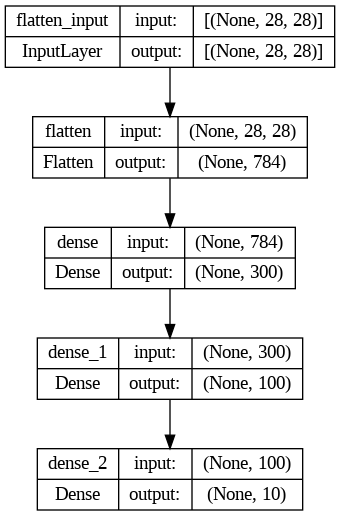

In [16]:
# 로컬에서 수행하려면 트리 구조를 출력했을 때처럼 graphviz 가 설치되어 있어야 함
# colab 에서는 바로 수행 가능
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

### 손실 함수

In [17]:
# 이진 분류 - 출력 노드의 갯수가 1개인 경우
model.compile(loss = 'binary_crossentropy')

In [18]:
# 출력이 둘 이상인 경우
model.compile(loss='categorical_crossentropy')

### Optimizer

In [19]:
model.compile(optimizer = 'adam', )

### 모델 컴파일

In [20]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=["accuracy"])

### 모델 훈련

In [21]:
history = model.fit(X_train, y_train, epochs = 25,
                    validation_data = (X_valid, y_valid))

Epoch 1/25
1719/1719 [==============================] - 19s 10ms/step - loss: 0.4809 - accuracy: 0.8256 - val_loss: 0.3610 - val_accuracy: 0.8708
Epoch 2/25
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3611 - accuracy: 0.8673 - val_loss: 0.4355 - val_accuracy: 0.8546
Epoch 3/25
  47/1719 [..............................] - ETA: 20s - loss: 0.3408 - accuracy: 0.8803

KeyboardInterrupt: ignored

### history 객체

In [ ]:
history.params

In [ ]:
history.history # loss, accuray 등에 대한 정보를 가지고 있음

### 학습 곡선 시각화

In [ ]:
pd.DataFrame(history.history).plot(figsize=(6, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

### 모델을 수정해서 학습

In [ ]:
# 모델 수정

model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(600, activation="relu"),
  keras.layers.Dense(600, activation="relu"),
  keras.layers.Dense(300, activation="relu"),
  keras.layers.Dense(300, activation="relu"),
  keras.layers.Dense(100, activation="relu"),
  keras.layers.Dense(50, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])

# 모델 컴파일 수정
adam_opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = adam_opt,
              loss = 'sparse_categorical_crossentropy',
              metrics=["accuracy"])

# 모델 훈련 과정 수정
history = model.fit(X_train, y_train, epochs = 50,
                    validation_data = (X_valid, y_valid))

In [ ]:
model.evaluate(X_test, y_test)

pd.DataFrame(history.history).plot(figsize=(6, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

### 예측

In [ ]:
# 테스트할 새로운 데이터가 없어서 기존 데이터 활용
X_new = X_test[:3]

# 각 클래스 별 확률
y_proba = model.predict(X_new)
y_proba.round(2)

In [ ]:
# 확률이 가장 높게 나타나는 클래스를 출력
y_pred = np.argmax(model.predict(X_new), axis = -1)
y_pred

In [ ]:
np.array(class_names)[y_pred]

In [ ]:
# 실제 이미지를 사용해서 비교

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
  plt.subplot(1, 3, index + 1)
  plt.imshow(image, cmap="binary", interpolation="nearest")
  plt.axis('off')
  plt.title(class_names[y_test[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# 캘리포니아 주택 가격 - 다항 회귀

## 데이터 가져오기

In [22]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

# 데이터 분리
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                  housing.target, random_state = 21)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                  y_train_full, random_state = 21)

scaler = StandardScaler()

# 정규화
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


In [23]:
np.random.seed(21)
tf.random.set_seed(21)

## 모델 생성

In [24]:
# 모델 만들기 - hidden layer 없음
model = keras.models.Sequential([
keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
keras.layers.Dense(1)
])

# 컴파일
# 손실 함수로 MSE, optimizer 로 SGD 사용
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(learning_rate = 1e-3),
              metrics = tf.keras.metrics.MeanSquaredError())

# 훈련
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# 평가
mse_test = model.evaluate(X_test, y_test)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.4603 - mean_squared_error: 2.4603 - val_loss: 1.0380 - val_mean_squared_error: 1.0380
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8617 - mean_squared_error: 0.8617 - val_loss: 0.8047 - val_mean_squared_error: 0.8047
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7592 - mean_squared_error: 0.7592 - val_loss: 0.7484 - val_mean_squared_error: 0.7484
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7152 - mean_squared_error: 0.7152 - val_loss: 0.7107 - val_mean_squared_error: 0.7107
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6815 - mean_squared_error: 0.6815 - val_loss: 0.6807 - val_mean_squared_error: 0.6807
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6521 - mean_squared_error: 0.6521 - val_loss: 0.6541 - val_mean_squared_error: 0.6541
Epoch 7/20
363/363 [========

In [25]:
# 예측
X_new = X_test[:3]
y_pred = model.predict(X_new)

print(y_test[:3])
print(y_pred)

1/1 [==============================] - 0s 84ms/step
[0.988 1.572 1.609]
[[0.69172597]
 [0.8198074 ]
 [1.8846104 ]]


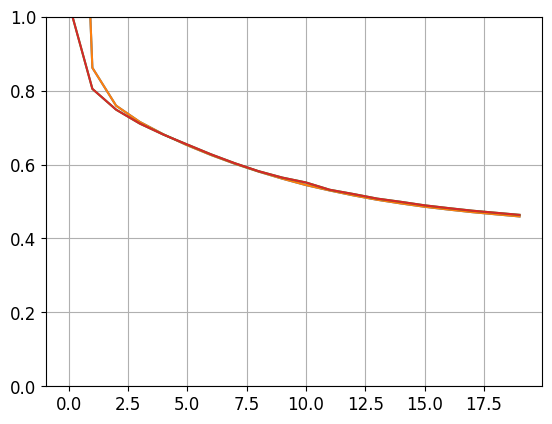

In [26]:
# 시각화해서 확인
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


## Functional API

### 모델 생성

In [27]:
# 입력 층을 생성 - 입력 층은 unit 이나 활성 함수가 의미 없음
input_ = keras.layers.Input(shape=X_train.shape[1:])

# input_ 다음에 연결되는 층을 생성
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
# hidden1 의 출력을 입력받는 층을 생성
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

# 이 층은 input_ 나 hidden2 의 출력을 입력으로 받는 층
# 연결의 기능만 수행하는 층이라서 unit 이나 활성 함수가 없음
concat = keras.layers.concatenate([input_, hidden2])

# concat 의 출력을 입력으로 받는 출력 층
output = keras.layers.Dense(1)(concat)

# 함수형 모델 생성
# inputs 에 input_ 층을, outputs 에 output 층을 설정
model = keras.models.Model(inputs=[input_], outputs=[output])

### 모델 확인

In [28]:
# 모델을 생성하는 부분만 다르고
# 나머지는 Sequential API 와 동일

model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(learning_rate = 1e-3),
              metrics = tf.keras.metrics.MeanSquaredError())

# 훈련
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# 평가
mse_test = model.evaluate(X_test, y_test)

Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 1.4292 - mean_squared_error: 1.4292 - val_loss: 0.6941 - val_mean_squared_error: 0.6941
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6510 - mean_squared_error: 0.6510 - val_loss: 0.6150 - val_mean_squared_error: 0.6150
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5957 - mean_squared_error: 0.5957 - val_loss: 0.5895 - val_mean_squared_error: 0.5895
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5687 - mean_squared_error: 0.5687 - val_loss: 0.5595 - val_mean_squared_error: 0.5595
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5482 - mean_squared_error: 0.5482 - val_loss: 0.5435 - val_mean_squared_error: 0.5435
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5342 - mean_squared_error: 0.5342 - val_loss: 0.5311 - val_mean_squared_error: 0.5311
Epoch 7/20
363/363 [========

In [29]:
# 예측
X_new = X_test[:3]
y_pred = model.predict(X_new)

print(y_test[:3])
print(y_pred)

1/1 [==============================] - 0s 61ms/step
[0.988 1.572 1.609]
[[0.4546582]
 [1.0223224]
 [1.8822273]]


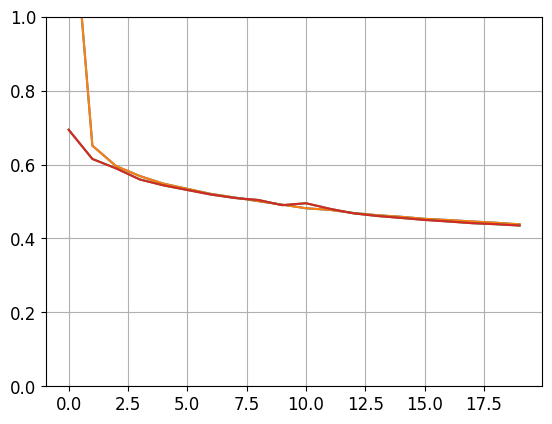

In [30]:
# 시각화해서 확인
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## 입력이 2개인 Functional API

In [31]:
np.random.seed(21)
tf.random.set_seed(21)

# 입력이 2개 - 입력 데이터를 2개의 묶음으로 나눠서 각각의 레이어로 보냄
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

# input_B 의 출력을 입력으로 사용
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
# hidden 1 의 출력을 입력으로 사용
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

# concatenate 를 사용해서 input_A 와 hidden2 의 출력을 묶어서 입력받음
concat = keras.layers.concatenate([input_A, hidden2])

output = keras.layers.Dense(1, name="output")(concat)

# 모델을 만들 때 2개의 입력을 사용하도록 설정
# fit 을 사용해서 훈련할 때에도 훈련 데이터가 2개 필요함
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

### 모델을 훈련

In [33]:
# 컴파일은 동일
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate = 1e-3))

# 입력을 2개로 만들어야 하기 때문에 기존의 데이터를 다시 2개로 분리
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

# 동일한 과정으로 훈련
# 차이점은 2개의 데이터를 입력으로 사용한다는 점
history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                  validation_data=((X_valid_A, X_valid_B), y_valid))

mse_test = model.evaluate((X_test_A, X_test_B), y_test)

y_pred = model.predict((X_new_A, X_new_B))


Epoch 1/20
363/363 [==============================] - 3s 6ms/step - loss: 0.5552 - val_loss: 0.5763
Epoch 2/20
363/363 [==============================] - 13s 37ms/step - loss: 0.5362 - val_loss: 0.5457
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5251 - val_loss: 0.5362
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5181 - val_loss: 0.5260
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5123 - val_loss: 0.5198
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5071 - val_loss: 0.5144
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5013 - val_loss: 0.5090
Epoch 8/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4965 - val_loss: 0.5055
Epoch 9/20
363/363 [==============================] - 2s 6ms/step - loss: 0.4915 - val_loss: 0.4986
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4872 - val_loss: 0.49

## 출력이 여러 개인 Functional API

In [34]:
np.random.seed(21)
tf.random.set_seed(21)

# 입력 층이 2개
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])

# 출력층1 - activation 이 없음
output = keras.layers.Dense(1, name="main_output")(concat)
# 출력층 2
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

# 모델에 보조 출력 추가하기
# 입력과 출력 모두 2개 - 모두 list 를 사용해서 여러 개를 지정
model = keras.models.Model(inputs=[input_A, input_B],
        outputs=[output, aux_output])

### 보조 출력이 추가된 모델 컴파일

In [36]:
# 각 모델에 사용할 loss function 을 리스트로 작성
# 더 중요하게 생각하는 output 에 대해 가중치를 설정할 수 있음
# ex) 자율주행에서는 사람을 인식하는 중요도가 자동차 인식보다 중요
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1],
      optimizer=keras.optimizers.SGD(learning_rate = 1e-3))

### 모델 훈련

In [38]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

# 동일한 과정으로 훈련
# 차이점은 2개의 데이터를 입력으로 사용한다는 점
history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                  validation_data=((X_valid_A, X_valid_B), y_valid))

mse_test = model.evaluate((X_test_A, X_test_B), y_test)

y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 2.4921 - main_output_loss: 2.2140 - aux_output_loss: 4.9954 - val_loss: 1.4085 - val_main_output_loss: 1.1365 - val_aux_output_loss: 3.8567
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 1.0532 - main_output_loss: 0.8452 - aux_output_loss: 2.9255 - val_loss: 0.9321 - val_main_output_loss: 0.7719 - val_aux_output_loss: 2.3746
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8467 - main_output_loss: 0.7133 - aux_output_loss: 2.0476 - val_loss: 0.8172 - val_main_output_loss: 0.7065 - val_aux_output_loss: 1.8132
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7647 - main_output_loss: 0.6672 - aux_output_loss: 1.6431 - val_loss: 0.7483 - val_main_output_loss: 0.6629 - val_aux_output_loss: 1.5167
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.7165 - main_output_loss: 0.6368 - aux_output_loss: 1.4336 - val_loss

### 모델 평가

In [41]:
total_loss, main_loss, aux_loss = model.evaluate(
      [X_test_A, X_test_B], [y_test, y_test])

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])


1/1 [==============================] - 0s 43ms/step


# 상속(SubClassing)을 이용한 방식

In [43]:
# keras 의 Model 클래스 상속
class WideAndDeepModel(keras.models.Model):
  # __init__ 은 파이썬 클래스의 초기화 함수 - 생성자와 유사함
  # __init__ 을 overriding(재정의) 할 때는 상위 클래스의 __init__ 을 반드시 호출해야 함
  def __init__(self, units=30, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.hidden1 = keras.layers.Dense(units, activation=activation)
    self.hidden2 = keras.layers.Dense(units, activation=activation)
    self.main_output = keras.layers.Dense(1)
    self.aux_output = keras.layers.Dense(1)

  # 모델이 수행할 동작을 갖는 method
  def call(self, inputs):
    input_A, input_B = inputs
    hidden1 = self.hidden1(input_B)
    hidden2 = self.hidden2(hidden1)
    concat = keras.layers.concatenate([input_A, hidden2])
    main_output = self.main_output(concat)
    aux_output = self.aux_output(hidden2)

    return main_output, aux_output

# Model 인스턴스를 생성하면 __init__ 에 작성한 내용이 자동으로 수행됨
model = WideAndDeepModel(30, activation="relu")

In [44]:
# 컴파일 및 훈련 과정은 이전과 동일함
# 모델을 만드는 과정이 달라졌을 뿐

model.compile(loss="mse", loss_weights=[0.9, 0.1],
  optimizer=keras.optimizers.SGD(learning_rate = 1e-3))

history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
  validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))

total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))

y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 4s 6ms/step - loss: 0.8982 - output_1_loss: 0.8172 - output_2_loss: 1.6272 - val_loss: 1.1964 - val_output_1_loss: 1.2054 - val_output_2_loss: 1.1160
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6239 - output_1_loss: 0.5780 - output_2_loss: 1.0370 - val_loss: 0.5276 - val_output_1_loss: 0.4741 - val_output_2_loss: 1.0091
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5080 - output_1_loss: 0.4625 - output_2_loss: 0.9181 - val_loss: 1.0034 - val_output_1_loss: 0.9858 - val_output_2_loss: 1.1615
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4999 - output_1_loss: 0.4627 - output_2_loss: 0.8348 - val_loss: 0.6171 - val_output_1_loss: 0.5908 - val_output_2_loss: 0.8536
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4680 - output_1_loss: 0.4363 - output_2_loss: 0.7530 - val_loss: 0.5081 - val_output_1_loss: 0.4803 - val_ou

1/1 [==============================] - 0s 162ms/step


# 모델을 저장하고 복원

In [45]:
# 모델을 만들고 컴파일, 훈련 과정은 동일
model = keras.models.Sequential([
  keras.layers.Dense(30, activation="relu", input_shape=[8]),
  keras.layers.Dense(30, activation="relu"),
  keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)


Epoch 1/10
363/363 [==============================] - 2s 4ms/step - loss: 0.7995 - val_loss: 0.8966
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5291 - val_loss: 0.5418
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4545 - val_loss: 0.5806
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4275 - val_loss: 0.4383
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4108 - val_loss: 0.4152
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4106 - val_loss: 0.4155
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.3893 - val_loss: 0.4572
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.3806 - val_loss: 0.4463
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.3748 - val_loss: 0.3849
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.3721


In [46]:
# 모델 저장 - 현재 디렉토리에 저장됨
# 디렉토리에서 확인 가능
# 다운로드 받아서 다른 곳으로 이동 가능

# 매개변수는 파일의 이름
model.save("my_keras_model.h5")

In [47]:
# 저장되어 있는 모델을 복원
model = keras.models.load_model("my_keras_model.h5")

# 복원된 모델을 가지고 확인
model.predict(X_new)

1/1 [==============================] - 0s 58ms/step


array([[0.88818204],
       [1.063429  ],
       [1.6605843 ]], dtype=float32)

## 모델의 가중치만 저장, 복원

In [48]:
# 가중치 저장 - 일반벅으로 확장자 명으로 ckpt 를 사용함
model.save_weights("my_keras_weights.ckpt")

# 가중치 불러오기
model.load_weights("my_keras_weights.ckpt")

# 콜 백(callback)

In [49]:
# 모델 생성
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(30, activation="relu", input_shape=[8]),
  keras.layers.Dense(30, activation="relu"),
  keras.layers.Dense(1)
])

## 체크 포인트

In [50]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# 체크 포인트 생성
# 체크 포인트의 이름을 매개변수로 지정 - my_keras_model.h5
# 최적의 모델을 저장 - save_best_only
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5",
  save_best_only=True)

# 모델을 훈련시킬 때 callback 을 매개변수를 사용해서 지정
# list 형태로 사용할 callback 을 지정
history = model.fit(X_train, y_train, epochs=10,
  validation_data=(X_valid, y_valid),
  callbacks=[checkpoint_cb])

# 가장 좋은 모델을 가져와서 롤백
model = keras.models.load_model("my_keras_model.h5")

mse_test = model.evaluate(X_test, y_test)


Epoch 1/10
363/363 [==============================] - 2s 5ms/step - loss: 0.8201 - val_loss: 0.6622
Epoch 2/10
363/363 [==============================] - 2s 4ms/step - loss: 0.4502 - val_loss: 0.6259
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4114 - val_loss: 0.5400
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4131 - val_loss: 2.8063
Epoch 5/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4149 - val_loss: 0.4398
Epoch 6/10
363/363 [==============================] - 1s 4ms/step - loss: 0.3904 - val_loss: 0.4597
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.3906 - val_loss: 0.4330
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.3704 - val_loss: 0.3619
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.3627 - val_loss: 0.3603
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.3657


## 조기 종료

In [ ]:
# 조기 종료

# patience 를 지정하는데 patience 동안 loss 가 줄어들지 않으면
# 훈련을 조기 중단하는 callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
    restore_best_weights=True)

# callback 으로 체크 포인트와 조기 종료를 사용
history = model.fit(X_train, y_train, epochs=100,
  validation_data=(X_valid, y_valid),
  callbacks=[checkpoint_cb, early_stopping_cb])
# 학습을 진행하다가 77번 epoch 에서 조기 종료됨
# 이후 다음 코드를 이어서 진행

mse_test = model.evaluate(X_test, y_test)


## 학습률 스케쥴러(LearningRateScheduler)

In [52]:
def scheduler(epoch, lr):
  tf.print(f'learning_rate: {lr:.5f}')
  # 첫 5 에포크 동안 유지
  if epoch < 5:
    return lr
  else:
    # 학습률 감소 적용
    return lr * tf.math.exp(-0.1)

# 콜백 객체생성 및 scheduler 함수 적용
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [54]:
# 초기 학습률 확인
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate = 1e-3))
print(round(model.optimizer.lr.numpy(), 5))


0.001


In [ ]:
# 콜 백 설정 후 학습
history = model.fit(X_train, y_train, epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler])

# 최종 학습률 스케줄러 확인
round(model.optimizer.lr.numpy(), 5)


## 사용자 정의 콜 백

In [56]:
#사용자 정의 콜백
# epoch 이 끝날 때 val_loss / loss 비율을 출력하도록 하는 함수
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

val_train_ratio_cb = PrintValTrainRatioCallback()

history = model.fit(X_train, y_train, epochs=1,
  validation_data=(X_valid, y_valid),
  callbacks=[val_train_ratio_cb])


359/363 [============================>.] - ETA: 0s - loss: 0.2657
val/train: 1.07
363/363 [==============================] - 2s 5ms/step - loss: 0.2649 - val_loss: 0.2825


## Tensorboard 를 이용한 시각화

In [57]:
# 로그를 저장하기 위한 디렉토리 경로를 설정
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
  import time

  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")

  return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2023_09_15-07_42_56'

In [ ]:
# tensorboard 활용

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(30, activation="relu", input_shape=[8]),
  keras.layers.Dense(30, activation="relu"),
  keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate = 1e-3))

# 텐서보드 저장 - validation 등 훈련 정보를 기록
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=30,
  validation_data=(X_valid, y_valid),
  callbacks=[checkpoint_cb, tensorboard_cb])


### 텐서보드 실행

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

# 신경망 하이퍼 파라미터 튜닝

## 함수 생성

In [61]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# keras 모델을 만들고 컴파일 하는 함수
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))

  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation="relu"))

  model.add(keras.layers.Dense(1))

  optimizer = keras.optimizers.SGD(lr=learning_rate)

  model.compile(loss="mse", optimizer=optimizer)

  return model


## 객체 생성

In [62]:
# 더 이상 tensorflow 에서 sklearn 의 warpper 를 제공하지 않으므로
# 사용하려면 scikeras 패키지를 이용해야 함

# 패키지 설치 필요
!pip install scikeras

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model())